In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image

In [2]:
TRAIN_PATH = f'../input/urdu-artificial-text-text-detection/UrTiV/Train/'
TEST_PATH = f'../input/urdu-artificial-text-text-detection/UrTiV/Test/'

# Loading the Data

### Training Data

In [3]:
df = pd.read_csv('../input/urdu-artificial-text-text-detection/UrTiV/csv_train.csv')
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,ARYNews12PM31stMay2022_436.jpg,900,600,ArtificialUrdu,49,439,713,503
1,ARYNews12PM31stMay2022_436.jpg,900,600,ArtificialUrdu,45,509,733,571
2,Sar-e-Aam3rdJune2022_995.jpg,900,600,ArtificialUrdu,98,32,797,87
3,Sar-e-Aam3rdJune2022_995.jpg,900,600,ArtificialUrdu,48,513,738,571
4,ARYNews12PM17thMay2022_236.jpg,900,600,ArtificialUrdu,50,440,718,497


### Testing Data

In [4]:
test_df = pd.read_csv('../input/urdu-artificial-text-text-detection/UrTiV/csv_test.csv')
test_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,ARYNews12PM2ndJune2022_88.jpg,900,600,ArtificialUrdu,69,438,684,501
1,ARYNews12PM2ndJune2022_88.jpg,900,600,ArtificialUrdu,85,508,700,575
2,Sar-e-Aam28thMay2022_222.jpg,900,600,ArtificialUrdu,123,34,745,89
3,Sar-e-Aam28thMay2022_222.jpg,900,600,ArtificialUrdu,59,513,721,569
4,SawalYehHai29thMay2022_446.jpg,900,600,ArtificialUrdu,265,35,535,78


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10047 entries, 0 to 10046
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  10047 non-null  object
 1   width     10047 non-null  int64 
 2   height    10047 non-null  int64 
 3   class     10047 non-null  object
 4   xmin      10047 non-null  int64 
 5   ymin      10047 non-null  int64 
 6   xmax      10047 non-null  int64 
 7   ymax      10047 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 628.1+ KB


In [6]:
df["filename"].value_counts().max() # maximum of nine boxes in an image

9

In [7]:
len(df["filename"].unique()), df["filename"].unique() #only 4343 images are there

(4343,
 array(['ARYNews12PM31stMay2022_436.jpg', 'Sar-e-Aam3rdJune2022_995.jpg',
        'ARYNews12PM17thMay2022_236.jpg', ...,
        'Sar-e-Aam3rdJune2022_998.jpg', 'SawalYehHai3rdJune2022_807.jpg',
        'AiterazHai8thMay2022_4.jpg'], dtype=object))

An image can contain multiple boxes and each box has separate entry in dataframe. So, this function returns a new dataframe which groups the image name and combines all the boxes of an image in a single array.

In [8]:
def reduce_dataframe(df):
    prev_image = df.loc[0, "filename"]
    new_df = pd.DataFrame(columns=["filename", "bounding_boxes"])
    i = 0
    while i < df.shape[0]:
        bounding_boxes = [[0]*4 for _ in range(9)]
        j = 0
        while i < df.shape[0] and df.loc[i, "filename"] == prev_image:
            #bounding_boxes.append(df.iloc[i, 4:])
            bounding_boxes[j] = df.iloc[i, 4:]
            i, j = i+1, j+1
        new_df.loc[len(new_df)] = [prev_image, bounding_boxes]
        prev_image = df.loc[i, "filename"] if i < df.shape[0] else None
    return new_df

In [9]:
new_train_df = reduce_dataframe(df)
new_train_df.head()

,filename,bounding_boxes
0,ARYNews12PM31stMay2022_436.jpg,"[[49, 439, 713, 503], [45, 509, 733, 571], [0,..."
1,Sar-e-Aam3rdJune2022_995.jpg,"[[98, 32, 797, 87], [48, 513, 738, 571], [0, 0..."
2,ARYNews12PM17thMay2022_236.jpg,"[[50, 440, 718, 497], [47, 511, 732, 569], [0,..."
3,ARYNews12PM29thMay2022_236.jpg,"[[47, 444, 713, 495], [49, 511, 734, 575], [0,..."
4,Sar-e-Aam14thMay2022_712.jpg,"[[132, 33, 460, 88], [47, 512, 735, 568], [0, ..."


In [10]:
new_test_df = reduce_dataframe(test_df)
new_test_df.head()

,filename,bounding_boxes
0,ARYNews12PM2ndJune2022_88.jpg,"[[69, 438, 684, 501], [85, 508, 700, 575], [0,..."
1,Sar-e-Aam28thMay2022_222.jpg,"[[123, 34, 745, 89], [59, 513, 721, 569], [0, ..."
2,SawalYehHai29thMay2022_446.jpg,"[[265, 35, 535, 78], [394, 453, 457, 493], [60..."
3,ARYNews12PM2ndJune2022_278.jpg,"[[49, 512, 732, 568], [0, 0, 0, 0], [0, 0, 0, ..."
4,ARYNews12PM2ndJune2022_244.jpg,"[[49, 443, 719, 493], [51, 515, 732, 569], [0,..."


Function below displays bounding boxes in the provided image around the specified region.

In [11]:
def show_bounding_boxes(img_arr, boxes):
    plt.imshow(img_arr, cmap="gray")
    for left, top, right, bottom in boxes:
        plt.plot([[left],[right]],[[bottom],[bottom]], 'r-')
        plt.plot([[left],[right]],[[top],[top]], 'r-')
        plt.plot([[left],[left]],[[top],[bottom]], 'r-')
        plt.plot([[right],[right]],[[top],[bottom]], 'r-')
    plt.axis('off')

In [12]:
def display_samples(X, y, title, rows=3, cols=3):
    """Displays multiple images in grid with their respective bounding boxes."""
    fig, axes = plt.subplots(rows, cols, figsize=(15,15))
    fig.suptitle(title, size=30)
    img_num = 0
    for i in range(rows):
        for j in range(cols):
            axes[i,j].imshow(X[img_num], cmap="gray")
            axes[i,j].set_title(img_num)
            axes[i,j].axis("off")
            for left, top, right, bottom in y[img_num]:
                axes[i,j].plot([[left],[right]],[[bottom],[bottom]], 'r-')
                axes[i,j].plot([[left],[right]],[[top],[top]], 'r-')
                axes[i,j].plot([[left],[left]],[[top],[bottom]], 'r-')
                axes[i,j].plot([[right],[right]],[[top],[bottom]], 'r-')
            img_num += 1
    fig.tight_layout(pad=2)
    plt.show()

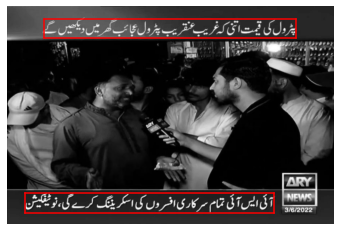

In [13]:
i = 4312
show_bounding_boxes(
    cv2.imread(os.path.join(TRAIN_PATH, new_train_df.loc[i, "filename"]), cv2.IMREAD_GRAYSCALE),
    new_train_df.loc[i, "bounding_boxes"]
)

Function for creating training and test set by loading image as grayscale and resizing them my 1/4th of the original size to save memory space.

In [14]:
def create_set(df, dir, resize_factor=1):
    img_path = f'../input/urdu-artificial-text-text-detection/UrTiV/{dir}'
    train_X, label_y = [], []
    for i in range(df.shape[0]):
        img = cv2.imread(os.path.join(img_path, df.loc[i, "filename"]), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img.shape[1] // resize_factor, img.shape[0] // resize_factor))
        img = img.reshape(img.shape[0], img.shape[1], 1)
        train_X.append(img)
        labels = np.asarray(df.loc[i, "bounding_boxes"]).astype("float32") // resize_factor
        label_y.append(labels)
    return (np.asarray(train_X).astype("float32"), np.asarray(label_y).astype("float32"))

In [15]:
train_X, train_y = create_set(new_train_df,"Train", resize_factor=4)
test_X, test_y = create_set(new_test_df,"Test", resize_factor=4)

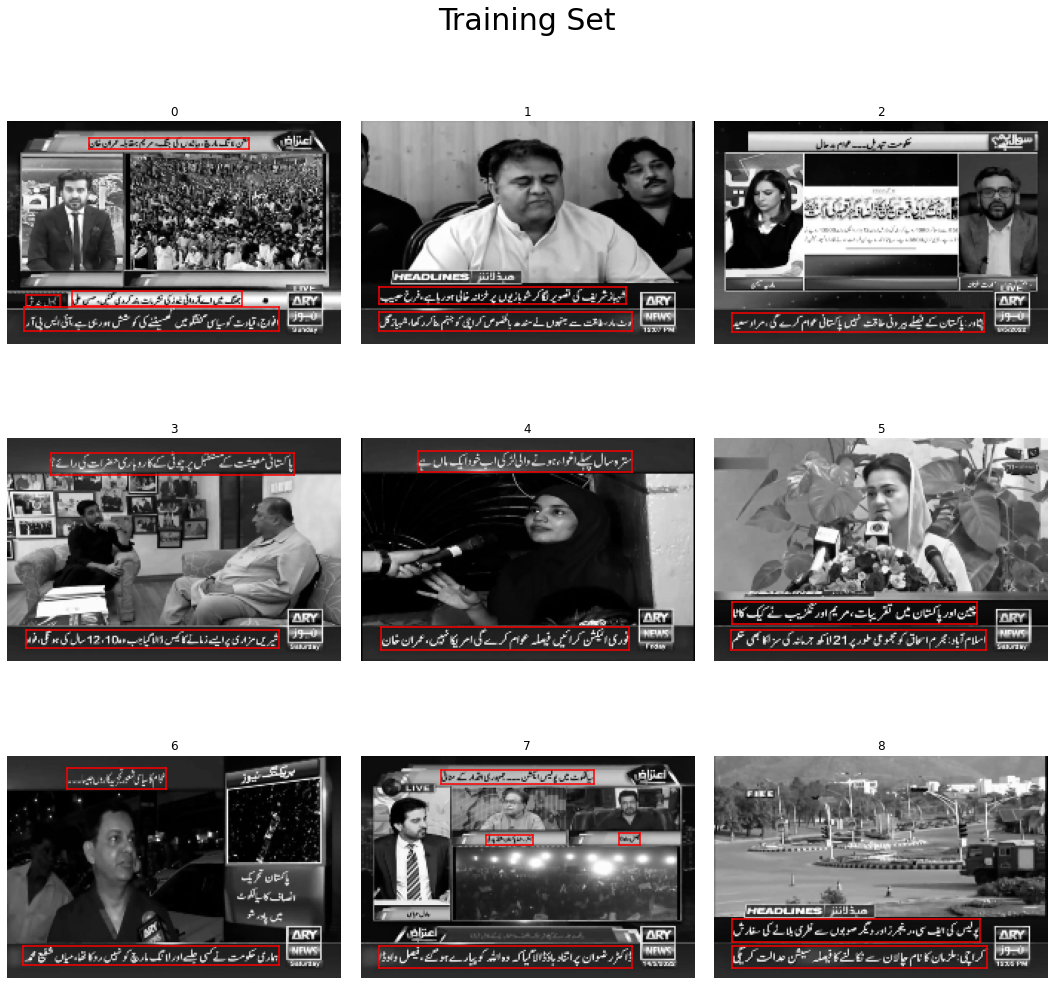

In [16]:
disp_X = train_X[1300:1309]
disp_y = train_y[1300:1309]
display_samples(disp_X, disp_y, "Training Set")

In [17]:
train_y.shape, train_X.shape, test_y.shape, test_X.shape

((4343, 9, 4), (4343, 150, 225, 1), (1083, 9, 4), (1083, 150, 225, 1))

# Creating Detection Model using CNN

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Flatten, Reshape, Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
input_shape = train_X.shape[1:]
model = Sequential([
    BatchNormalization(input_shape=input_shape),
    
    Conv2D(16, (3,3), activation="relu"),
    MaxPooling2D(),
    
    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D(),
    
    Dropout(0.3),
    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(),
    
    Dropout(0.3),
    Conv2D(128, (3,3), activation="relu"),
    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(),
    
    Dropout(0.3),
    Conv2D(32, (3,3), activation="relu"),
    Flatten(),
    Dense(500, activation="relu"),
    Dense(250, activation="relu"),
    Dense(36),
    Reshape((9,4))
])

2022-09-18 05:37:15.561797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 05:37:15.678082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 05:37:15.679070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 05:37:15.680722: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 150, 225, 1)       4         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 223, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 111, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 109, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 54, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 52, 64)        1

Optimizer: Adadelta

In [21]:
model.compile(
    optimizer="adadelta",
    loss="mae",
    metrics=["accuracy"]
)

In [22]:
history = model.fit(
    train_X, train_y,
    validation_data=(test_X, test_y),
    batch_size=10,
    epochs=20,
    verbose=1,
    callbacks=[EarlyStopping(monitor="val_loss",min_delta=0.001,patience=5,restore_best_weights=True)]
)

2022-09-18 05:37:19.869170: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-09-18 05:37:21.480880: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


435/435 [==============================] - 12s 10ms/step - loss: 25.2008 - accuracy: 0.0615 - val_loss: 25.6617 - val_accuracy: 0.1207
Epoch 2/20
435/435 [==============================] - 4s 8ms/step - loss: 25.1716 - accuracy: 0.1209 - val_loss: 25.6562 - val_accuracy: 0.1832
Epoch 3/20
435/435 [==============================] - 4s 8ms/step - loss: 25.1565 - accuracy: 0.1510 - val_loss: 25.6478 - val_accuracy: 0.2191
Epoch 4/20
435/435 [==============================] - 4s 8ms/step - loss: 25.1269 - accuracy: 0.1599 - val_loss: 25.6186 - val_accuracy: 0.1849
Epoch 5/20
435/435 [==============================] - 4s 8ms/step - loss: 24.9298 - accuracy: 0.1551 - val_loss: 25.1476 - val_accuracy: 0.1895
Epoch 6/20
435/435 [==============================] - 4s 8ms/step - loss: 15.7596 - accuracy: 0.3120 - val_loss: 15.3539 - val_accuracy: 0.4505
Epoch 7/20
435/435 [==============================] - 4s 9ms/step - loss: 11.3221 - accuracy: 0.3971 - val_loss: 14.8187 - val_accuracy: 0.4379
E

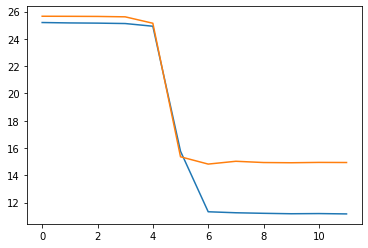

In [23]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

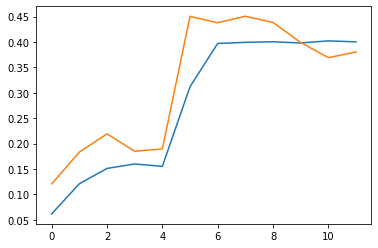

In [24]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Optimizer: SGD

In [25]:
model.compile(
    optimizer="sgd",
    loss="mae",
    metrics=["accuracy"]
)

In [26]:
history = model.fit(
    train_X, train_y,
    validation_data=(test_X, test_y),
    batch_size=10,
    epochs=20,
    verbose=1,
    callbacks=[EarlyStopping(monitor="val_loss",min_delta=0.001,patience=5,restore_best_weights=True)]
)

Epoch 1/20
435/435 [==============================] - 4s 9ms/step - loss: 25.1374 - accuracy: 0.3281 - val_loss: 25.6155 - val_accuracy: 0.3033
Epoch 2/20
435/435 [==============================] - 4s 8ms/step - loss: 25.0858 - accuracy: 0.2923 - val_loss: 25.5555 - val_accuracy: 0.3266
Epoch 3/20
435/435 [==============================] - 3s 8ms/step - loss: 24.9979 - accuracy: 0.3015 - val_loss: 25.4303 - val_accuracy: 0.3341
Epoch 4/20
435/435 [==============================] - 3s 8ms/step - loss: 24.7455 - accuracy: 0.3085 - val_loss: 24.9561 - val_accuracy: 0.1453
Epoch 5/20
435/435 [==============================] - 4s 8ms/step - loss: 19.6205 - accuracy: 0.3423 - val_loss: 12.6201 - val_accuracy: 0.3274
Epoch 6/20
435/435 [==============================] - 4s 9ms/step - loss: 11.5490 - accuracy: 0.4306 - val_loss: 12.6629 - val_accuracy: 0.4181
Epoch 7/20
435/435 [==============================] - 3s 8ms/step - loss: 10.8589 - accuracy: 0.4004 - val_loss: 12.8734 - val_accuracy:

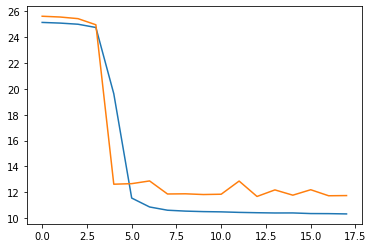

In [27]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

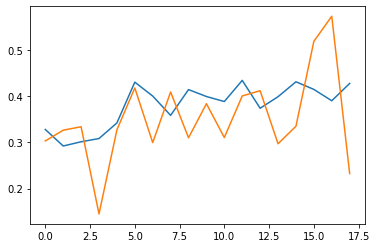

In [28]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Optimizer: Adagrad

In [29]:
model.compile(
    optimizer="adagrad",
    loss="mae",
    metrics=["accuracy"]
)

In [30]:
history = model.fit(
    train_X, train_y,
    validation_data=(test_X, test_y),
    batch_size=10,
    epochs=20,
    verbose=1,
    callbacks=[EarlyStopping(monitor="val_accuracy",min_delta=0.001,patience=5,restore_best_weights=True)]
)

Epoch 1/20
435/435 [==============================] - 4s 9ms/step - loss: 9.9587 - accuracy: 0.3990 - val_loss: 11.3860 - val_accuracy: 0.5288
Epoch 2/20
435/435 [==============================] - 4s 8ms/step - loss: 9.9369 - accuracy: 0.4128 - val_loss: 11.3816 - val_accuracy: 0.4220
Epoch 3/20
435/435 [==============================] - 4s 8ms/step - loss: 9.9281 - accuracy: 0.4095 - val_loss: 11.3730 - val_accuracy: 0.3562
Epoch 4/20
435/435 [==============================] - 3s 8ms/step - loss: 9.9254 - accuracy: 0.4085 - val_loss: 11.3684 - val_accuracy: 0.4877
Epoch 5/20
435/435 [==============================] - 4s 9ms/step - loss: 9.9182 - accuracy: 0.4138 - val_loss: 11.3643 - val_accuracy: 0.6416
Epoch 6/20
435/435 [==============================] - 4s 8ms/step - loss: 9.9165 - accuracy: 0.4162 - val_loss: 11.3797 - val_accuracy: 0.5122
Epoch 7/20
435/435 [==============================] - 3s 8ms/step - loss: 9.9152 - accuracy: 0.4123 - val_loss: 11.3676 - val_accuracy: 0.4238

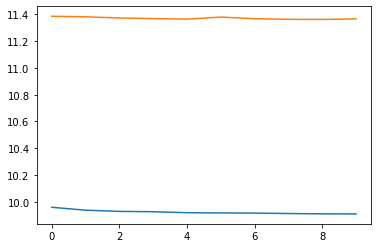

In [31]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

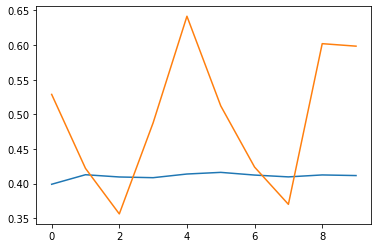

In [32]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Optimizer: adam

In [33]:
model.compile(
    optimizer="adam",
    loss="mae",
    metrics=["accuracy"]
)

In [34]:
history = model.fit(
    train_X, train_y,
    validation_data=(test_X, test_y),
    batch_size=10,
    epochs=20,
    verbose=1,
    callbacks=[EarlyStopping(monitor="val_accuracy",min_delta=0.001,patience=5,restore_best_weights=True)]
)

Epoch 1/20
435/435 [==============================] - 5s 9ms/step - loss: 9.9971 - accuracy: 0.4096 - val_loss: 11.1718 - val_accuracy: 0.2976
Epoch 2/20
435/435 [==============================] - 3s 8ms/step - loss: 9.4019 - accuracy: 0.4181 - val_loss: 11.1006 - val_accuracy: 0.2714
Epoch 3/20
435/435 [==============================] - 4s 9ms/step - loss: 8.7998 - accuracy: 0.4111 - val_loss: 11.0447 - val_accuracy: 0.4534
Epoch 4/20
435/435 [==============================] - 4s 9ms/step - loss: 8.0096 - accuracy: 0.4158 - val_loss: 9.0957 - val_accuracy: 0.2783
Epoch 5/20
435/435 [==============================] - 3s 8ms/step - loss: 6.4898 - accuracy: 0.4313 - val_loss: 8.6398 - val_accuracy: 0.3815
Epoch 6/20
435/435 [==============================] - 3s 8ms/step - loss: 6.1150 - accuracy: 0.4289 - val_loss: 8.5130 - val_accuracy: 0.3805
Epoch 7/20
435/435 [==============================] - 4s 8ms/step - loss: 5.2420 - accuracy: 0.4351 - val_loss: 6.6257 - val_accuracy: 0.4421
Epo

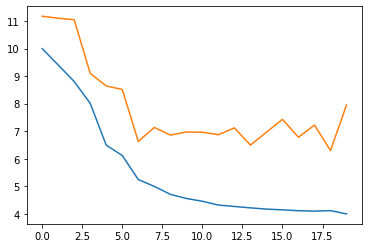

In [35]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

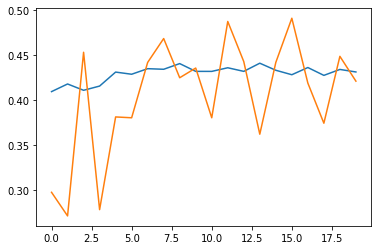

In [36]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

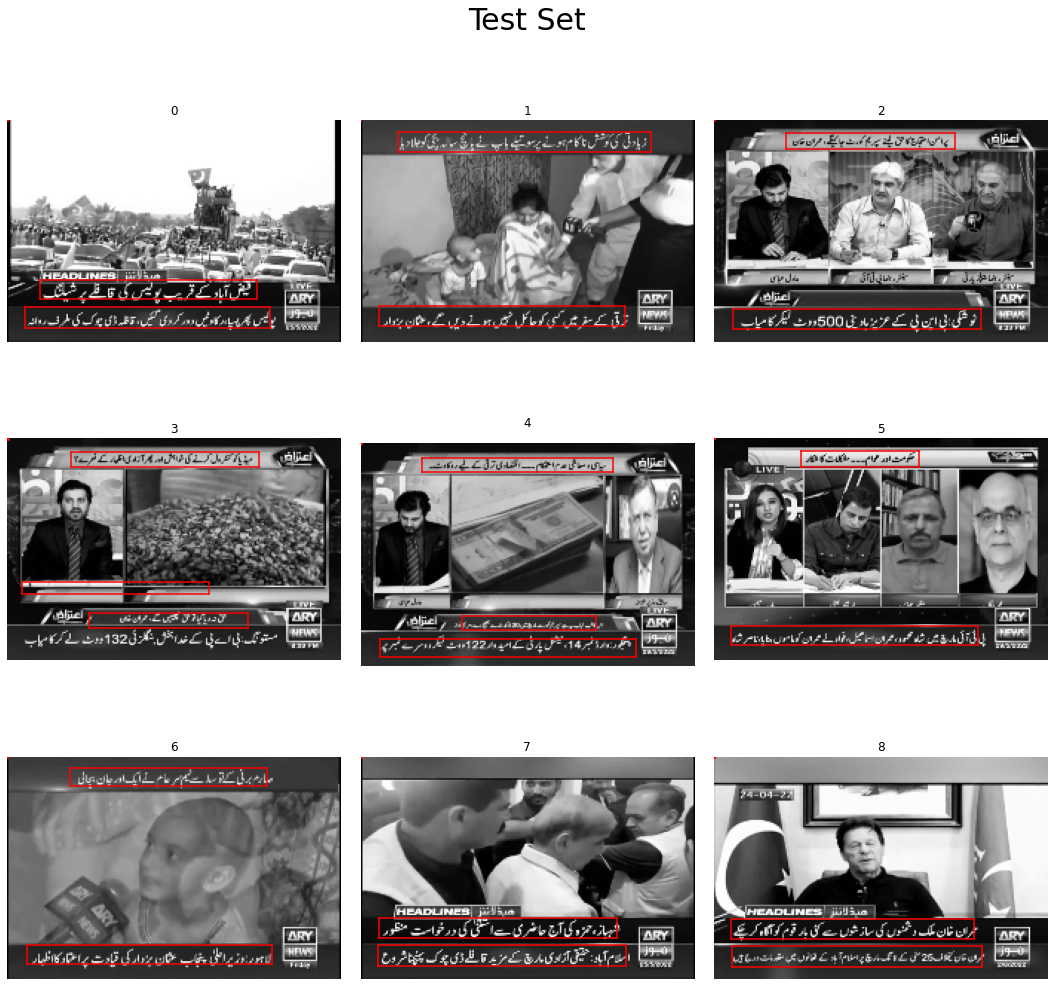

In [37]:
disp_X = test_X[100:109]
disp_y = model.predict(disp_X)
display_samples(disp_X, disp_y, "Test Set")